In [42]:
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches # Para dibujar rectángulos
import numpy as np
from PIL import Image
from io import BytesIO
import os
from dotenv import load_dotenv

In [ ]:
# Configuración API Azure
load_dotenv()
subscription_key = os.getenv("AZURE_VISION_KEY")
endpoint = os.getenv("AZURE_VISION_ENDPOINT")

In [44]:
if not subscription_key or not endpoint:
    print("Error: Asegúrate de que las variables AZURE_VISION_KEY y AZURE_VISION_ENDPOINT estén definidas en tu archivo .env")
    exit()

# La URL se construye ahora con las variables cargadas
if not endpoint.endswith('/'): # Asegurarse que el endpoint termine en '/'
    endpoint += '/'
analyze_url_v32 = endpoint + "vision/v3.2/analyze"
print(f"Usando URL para v3.2: {analyze_url_v32}") # Verifica que la URL se construya bien

Usando URL para v3.2: https://talentotechcomputervision.cognitiveservices.azure.com/vision/v3.2/analyze


In [45]:
# Función para cargar y mostrar una imagen
def load_and_show_image(image_path, show=True):
    if not os.path.exists(image_path):
        print(f"Error: No se encontró la imagen en la ruta: {image_path}")
        return None
    try:
        image = Image.open(image_path)
        if show:
            print(f"Imagen original ({image.mode}, {image.size}):")
            plt.figure(figsize=(8, 8)) # Ajustar tamaño si es necesario
            plt.imshow(image)
            plt.axis('off')
            plt.title("Imagen Original")
            plt.show()
        return image
    except Exception as e:
        print(f"Error al cargar o mostrar la imagen: {e}")
        return None

In [46]:
# Función para detectar objetos
def detect_objects_v32(image_path):
    if not os.path.exists(image_path):
        print(f"Error: No se encontró la imagen en la ruta: {image_path}")
        return None

    # Leer la imagen como datos binarios
    try:
        with open(image_path, "rb") as image_file:
            image_data = image_file.read()
    except Exception as e:
        print(f"Error al leer el archivo de imagen: {e}")
        return None

    # Configurar Headers y Params para v3.2 Object Detection
    headers = {'Ocp-Apim-Subscription-Key': subscription_key,
               'Content-Type': 'application/octet-stream'}
    # Especificar 'Objects' como la característica visual deseada
    params = {'visualFeatures': 'Objects'}

    # Realizar la solicitud POST a la API v3.2
    try:
        print(f"Enviando solicitud de detección de objetos a Azure AI Vision v3.2 ({analyze_url_v32})...")
        response = requests.post(analyze_url_v32, headers=headers, params=params, data=image_data)
        response.raise_for_status() # Verifica si hubo errores HTTP (4xx o 5xx)
        print("Solicitud v3.2 exitosa!")

        # --- Procesar la respuesta de v3.2 ---
        analysis = response.json()

        # Verificar si la detección de objetos está en la respuesta
        if 'objects' in analysis:
            detected_objects = analysis['objects']
            print(f"Se detectaron {len(detected_objects)} objetos.")
            return detected_objects # Devuelve la lista de objetos detectados
        else:
            print("Error: La respuesta de la API v3.2 no contiene 'objects'. Respuesta recibida:")
            print(analysis)
            return None # Devuelve None si no se encontraron objetos o hubo un error

    except requests.exceptions.Timeout as e:
        print(f"Error: La solicitud tardó demasiado tiempo (Timeout): {e}")
        print(f"URL intentada: {analyze_url_v32}")
        return None
    except requests.exceptions.RequestException as e:
        print(f"Error en la solicitud HTTP: {e}")
        print(f"URL intentada: {analyze_url_v32}")
        if e.response is not None:
            print(f"Código de estado: {e.response.status_code}")
            try:
                error_details = e.response.json()
                print(f"Detalles del error: {error_details}")
            except requests.exceptions.JSONDecodeError:
                print(f"Contenido de la respuesta (no JSON): {e.response.text}")
        return None
    except Exception as e:
        print(f"Ocurrió un error inesperado durante la detección de objetos v3.2: {e}")
        return None


In [47]:
def show_objects_on_image(original_image, detected_objects):
    if original_image is None or detected_objects is None:
        print("Error: No se puede mostrar resultados sin imagen original u objetos detectados.")
        return

    fig, ax = plt.subplots(1, figsize=(10, 10)) # Crear figura y ejes
    ax.imshow(original_image) # Mostrar la imagen original

    print("\nDibujando cuadros delimitadores:")
    # Iterar sobre los objetos detectados
    for obj in detected_objects:
        if 'rectangle' in obj and 'object' in obj and 'confidence' in obj:
            rect = obj['rectangle'] # x, y, w, h
            obj_name = obj['object']
            confidence = obj['confidence']

            # Crear el rectángulo (x, y son esquina superior izquierda)
            bounding_box = patches.Rectangle(
                (rect['x'], rect['y']), rect['w'], rect['h'],
                linewidth=2, edgecolor='lime', facecolor='none' # Color lima, sin relleno
            )
            # Añadir el rectángulo al plot
            ax.add_patch(bounding_box)

            # Añadir etiqueta con nombre y confianza
            label = f"{obj_name}: {confidence:.2f}"
            print(f"- {label} en ({rect['x']}, {rect['y']}, {rect['w']}, {rect['h']})")
            plt.text(rect['x'], rect['y'] - 10, label, color='lime', fontsize=10,
                     bbox=dict(facecolor='black', alpha=0.6, pad=0.2, edgecolor='none')) # Texto sobre el cuadro

    plt.axis('off') # Ocultar ejes
    plt.title("Objetos Detectados (API v3.2)")
    plt.show()

In [48]:
# Cargar y mostrar la imagen original
image_path = "paneles_solares.jpg"
original_image = load_and_show_image(image_path, show=False)


Intentando detectar objetos con API v3.2...
Enviando solicitud de detección de objetos a Azure AI Vision v3.2 (https://talentotechcomputervision.cognitiveservices.azure.com/vision/v3.2/analyze)...
Solicitud v3.2 exitosa!
Se detectaron 1 objetos.

Dibujando cuadros delimitadores:
- dormer window: 0.62 en (370, 162, 205, 112)


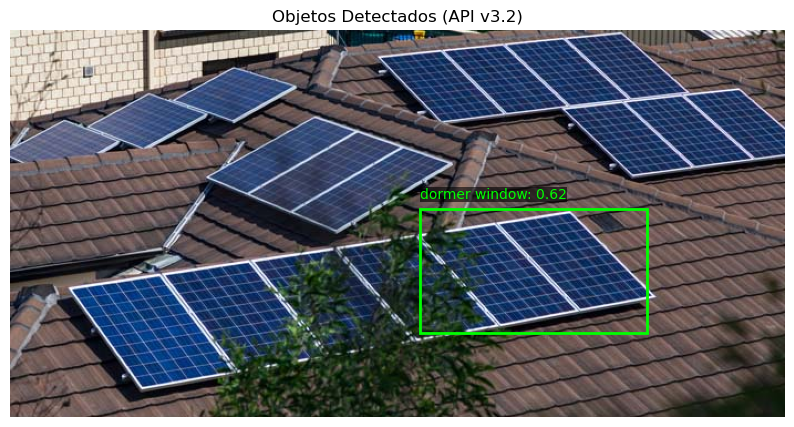

In [49]:
if original_image:
    # 2. Detectar objetos usando v3.2
    print("\nIntentando detectar objetos con API v3.2...")
    objects_found = detect_objects_v32(image_path)

    # 3. Mostrar la imagen original CON los cuadros delimitadores si se encontraron objetos
    if objects_found is not None:
        if objects_found: # Si la lista no está vacía
             show_objects_on_image(original_image, objects_found)
        else:
             print("\nLa API respondió correctamente, pero no se detectaron objetos en la imagen.")
             # Opcional: mostrar la imagen original si no se detectó nada
             plt.figure(figsize=(8, 8))
             plt.imshow(original_image)
             plt.axis('off')
             plt.title("Imagen Original (No se detectaron objetos)")
             plt.show()
    else:
        print("\nNo se pudo obtener la detección de objetos de la API v3.2.")
else:
    print("\nNo se pudo cargar la imagen original. Verifica la ruta y el archivo.")